# Mustang 2 playground

Questions:
- How does reconstruction change if truth sampling stays the same?
- Can we do a simple power-spectrum fit and substract?

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

import maria

In [2]:
from maria.io import fetch
map_filename = fetch("maps/cluster.fits")

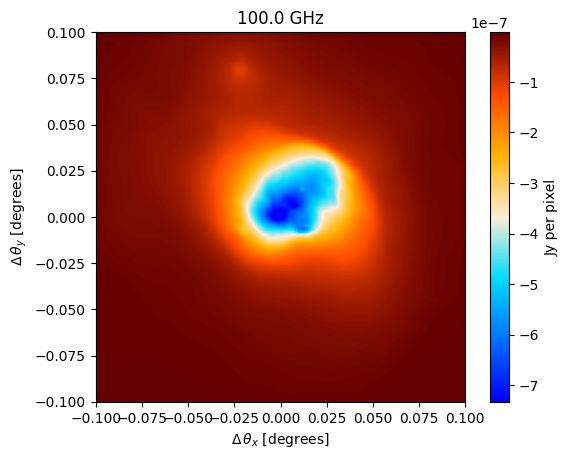

In [3]:
# load in the map from a fits file
input_map = maria.map.from_fits(filename=map_filename, #filename
                                resolution=2e-04, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map
                               )
input_map.plot()

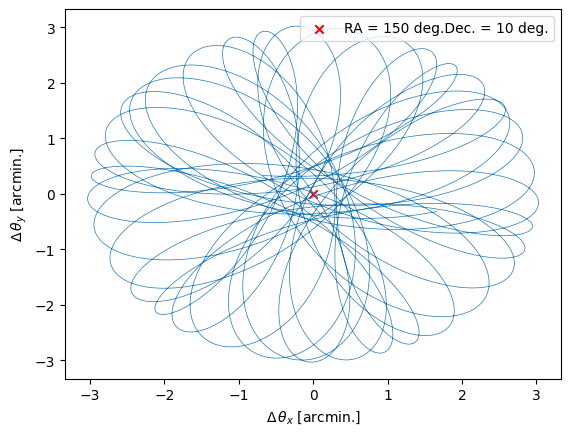

In [4]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds  
                      sample_rate=100, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

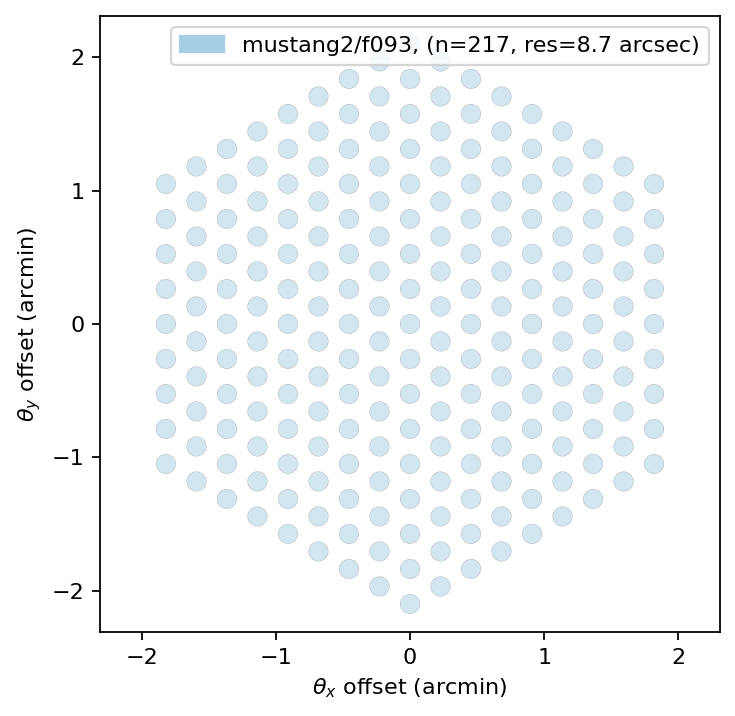

In [5]:
instrument = maria.get_instrument('MUSTANG-2')
instrument.plot()

In [6]:
sim = maria.Simulation(instrument,
                       plan=plan,
                       site="llano_de_chajnantor",
                       map=input_map,
                       atmosphere="2d",
                      )

Initialized base in 1218 ms.


Initializing atmospheric layers: 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


In [7]:
todarr = []
for i in range(7):
    print("Running sim no: ", i)
    tod = sim.run()

    # Hacky way of recovering 'data' for now:
    tod.components['map'] *= 1e5
    # tod.components['map'] *= 0
    # tod.components['atmosphere'] *= 0
    # tod.components['noise'] *= 0
    todarr += [tod]

Running sim no:  0


Generating noise: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]
Generating atmosphere: 4it [00:00,  4.94it/s]
Sampling map (mustang2/f093): 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


Running sim no:  1


Generating noise: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]
Generating atmosphere: 4it [00:00,  4.83it/s]
Sampling map (mustang2/f093): 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


Running sim no:  2


Generating noise: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]
Generating atmosphere: 4it [00:00,  4.88it/s]
Sampling map (mustang2/f093): 100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


Running sim no:  3


Generating noise: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]
Generating atmosphere: 4it [00:00,  4.75it/s]
Sampling map (mustang2/f093): 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


Running sim no:  4


Generating noise: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]
Generating atmosphere: 4it [00:00,  4.93it/s]
Sampling map (mustang2/f093): 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


Running sim no:  5


Generating noise: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]
Generating atmosphere: 4it [00:00,  4.80it/s]
Sampling map (mustang2/f093): 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


Running sim no:  6


Generating noise: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]
Generating atmosphere: 4it [00:00,  4.85it/s]
Sampling map (mustang2/f093): 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


In [8]:
tod.data

dask.array<add, shape=(217, 60000), dtype=float32, chunksize=(217, 60000), chunktype=numpy.ndarray>

In [9]:
tod.components['atmosphere']

dask.array<array, shape=(217, 60000), dtype=float32, chunksize=(217, 60000), chunktype=numpy.ndarray>

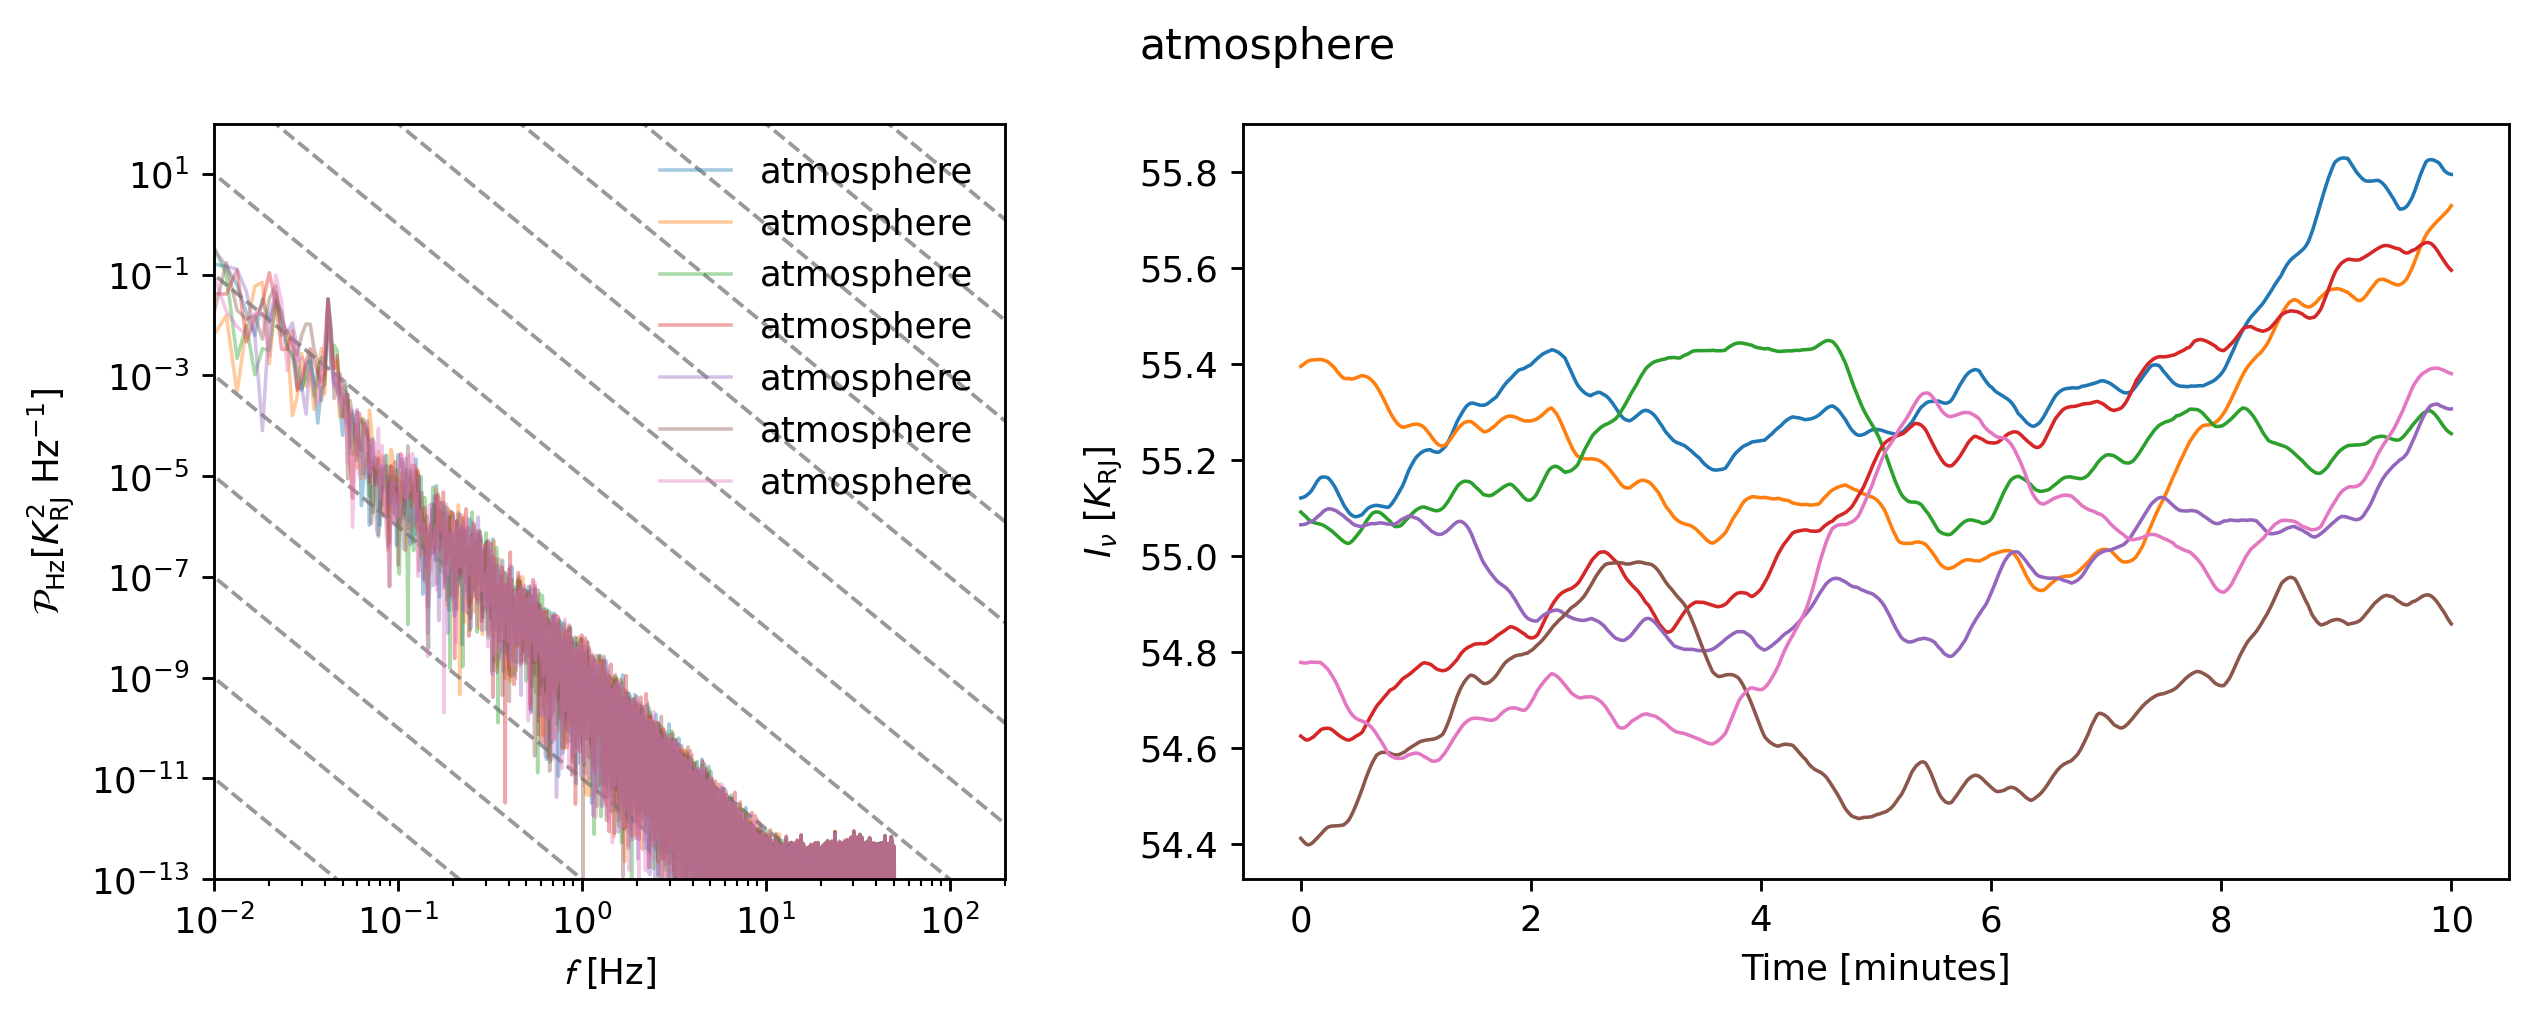

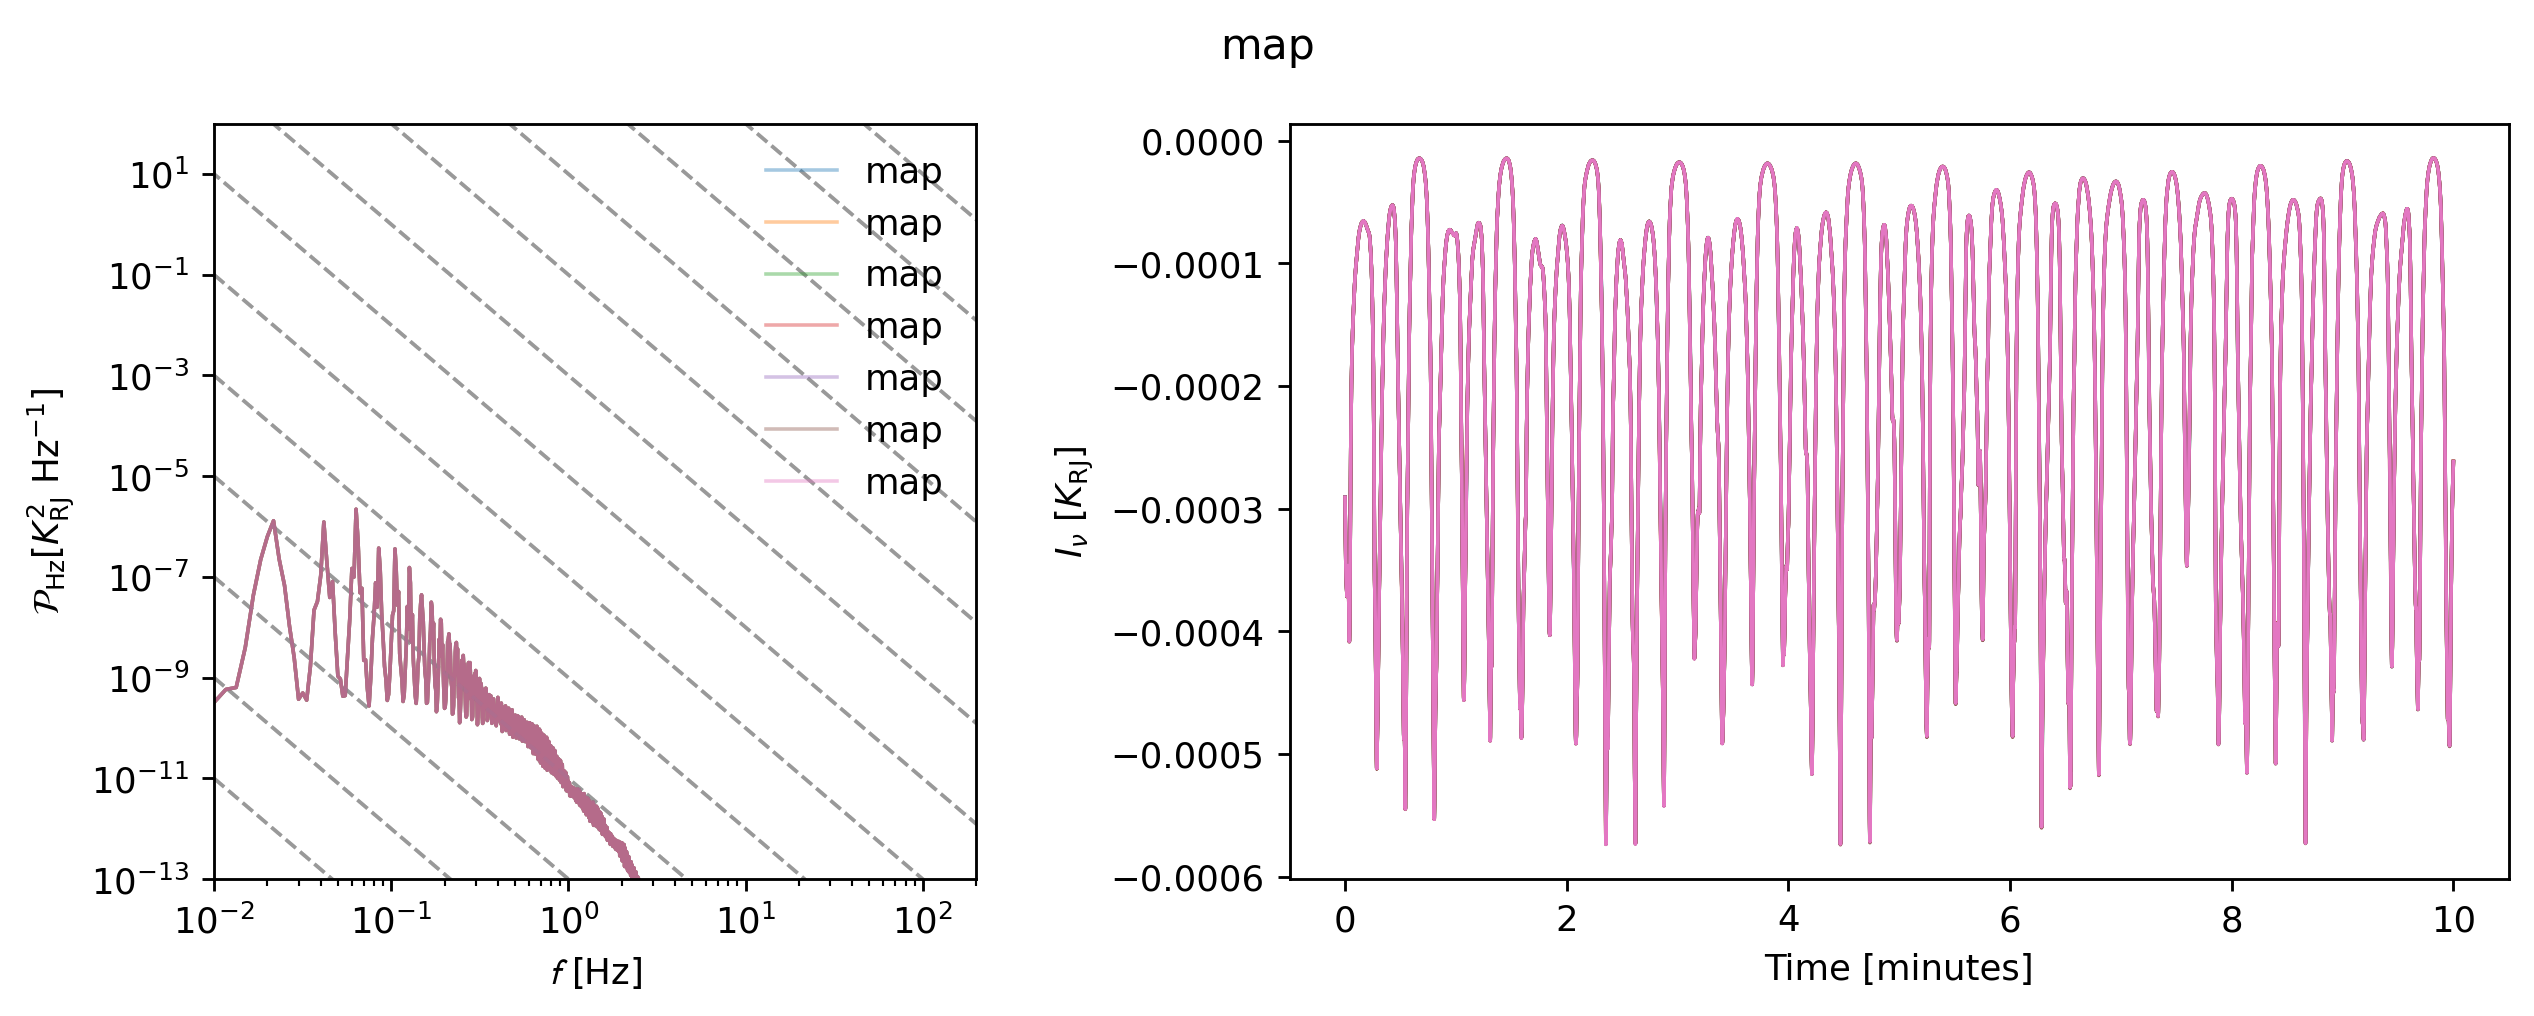

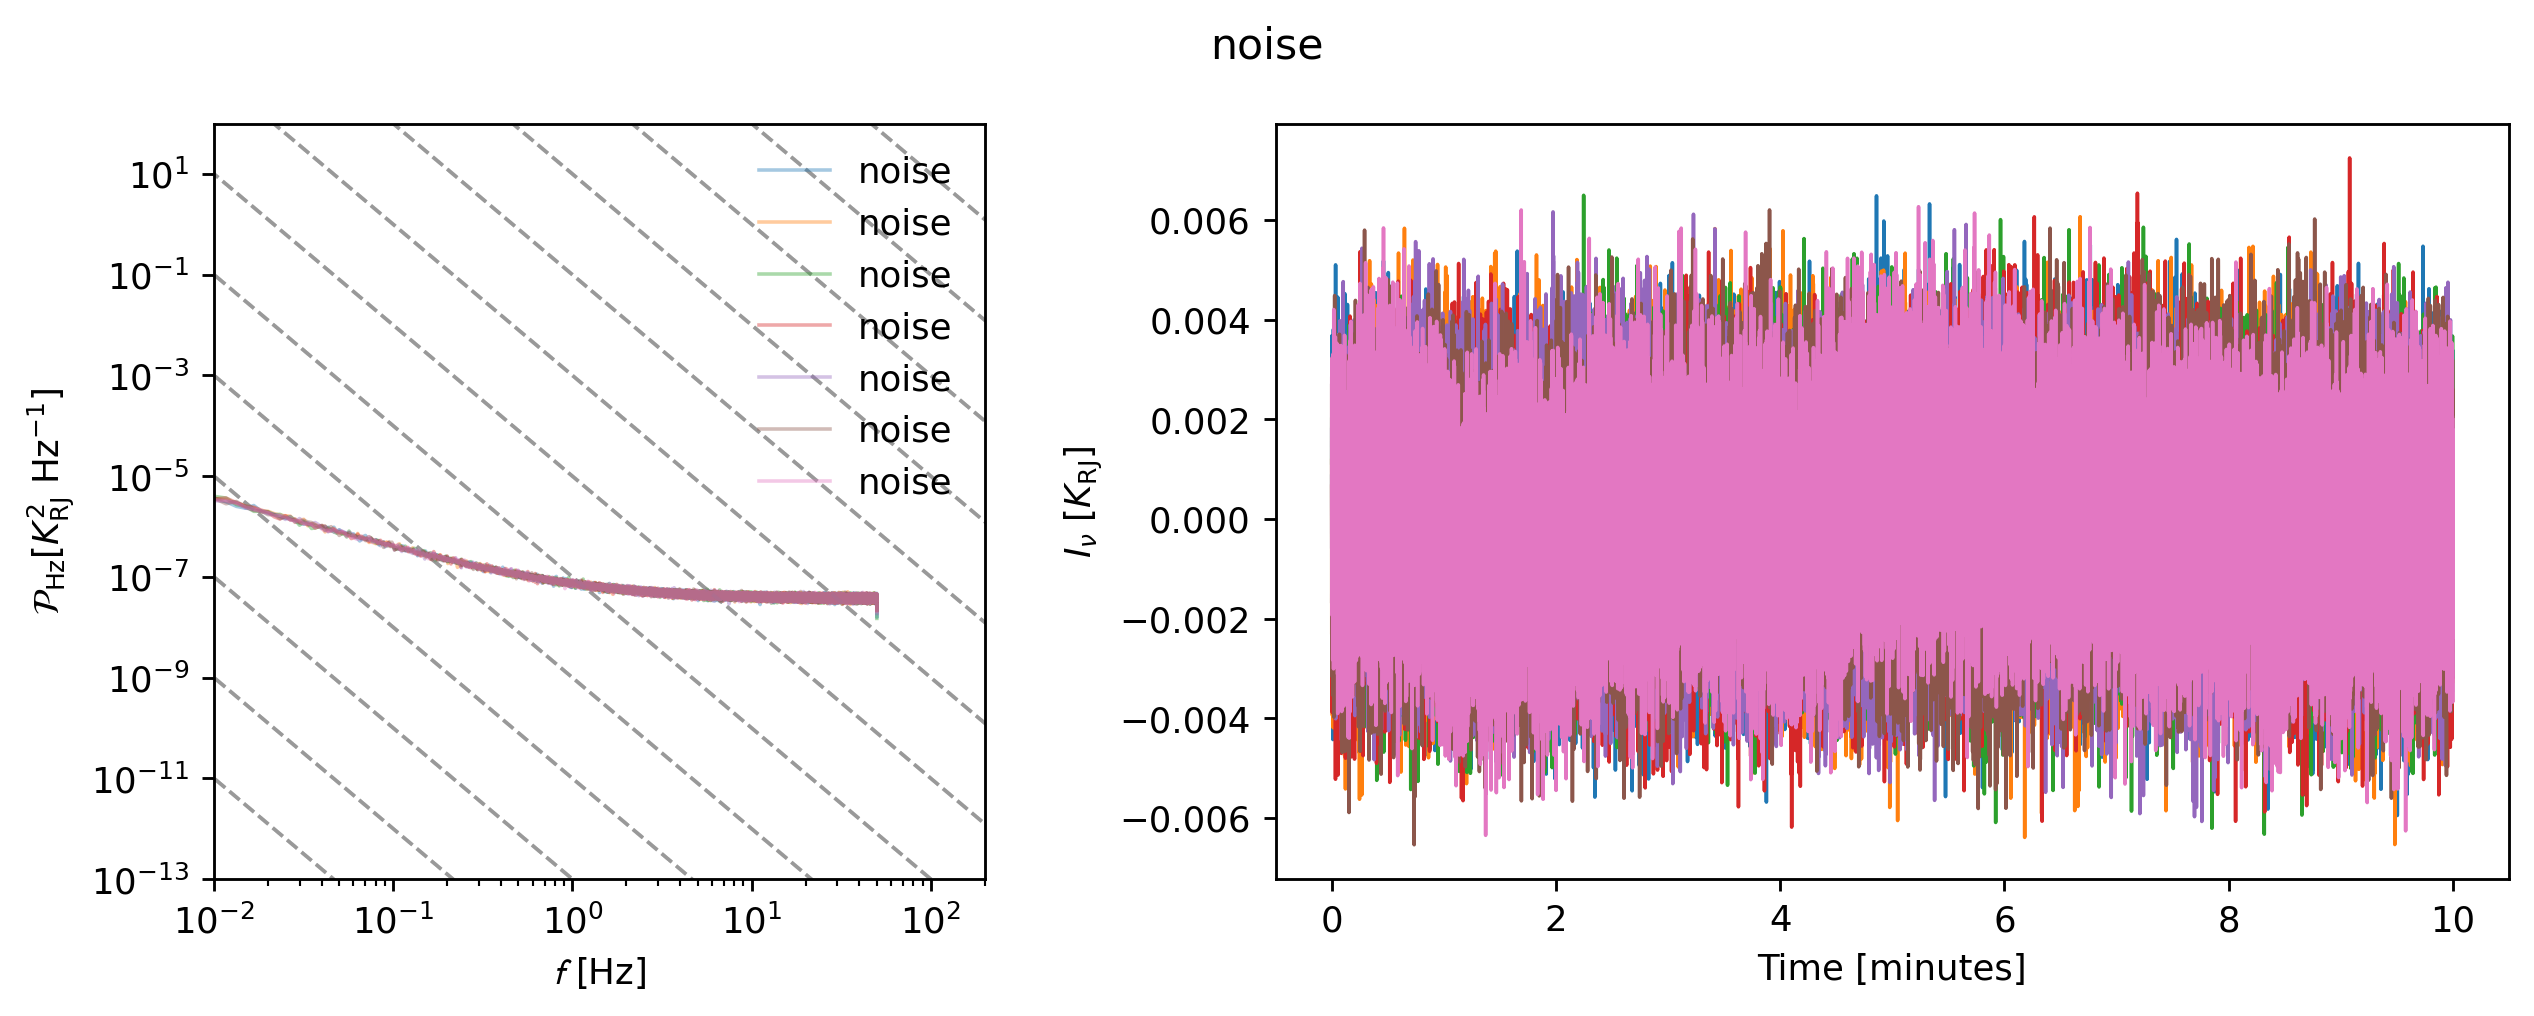

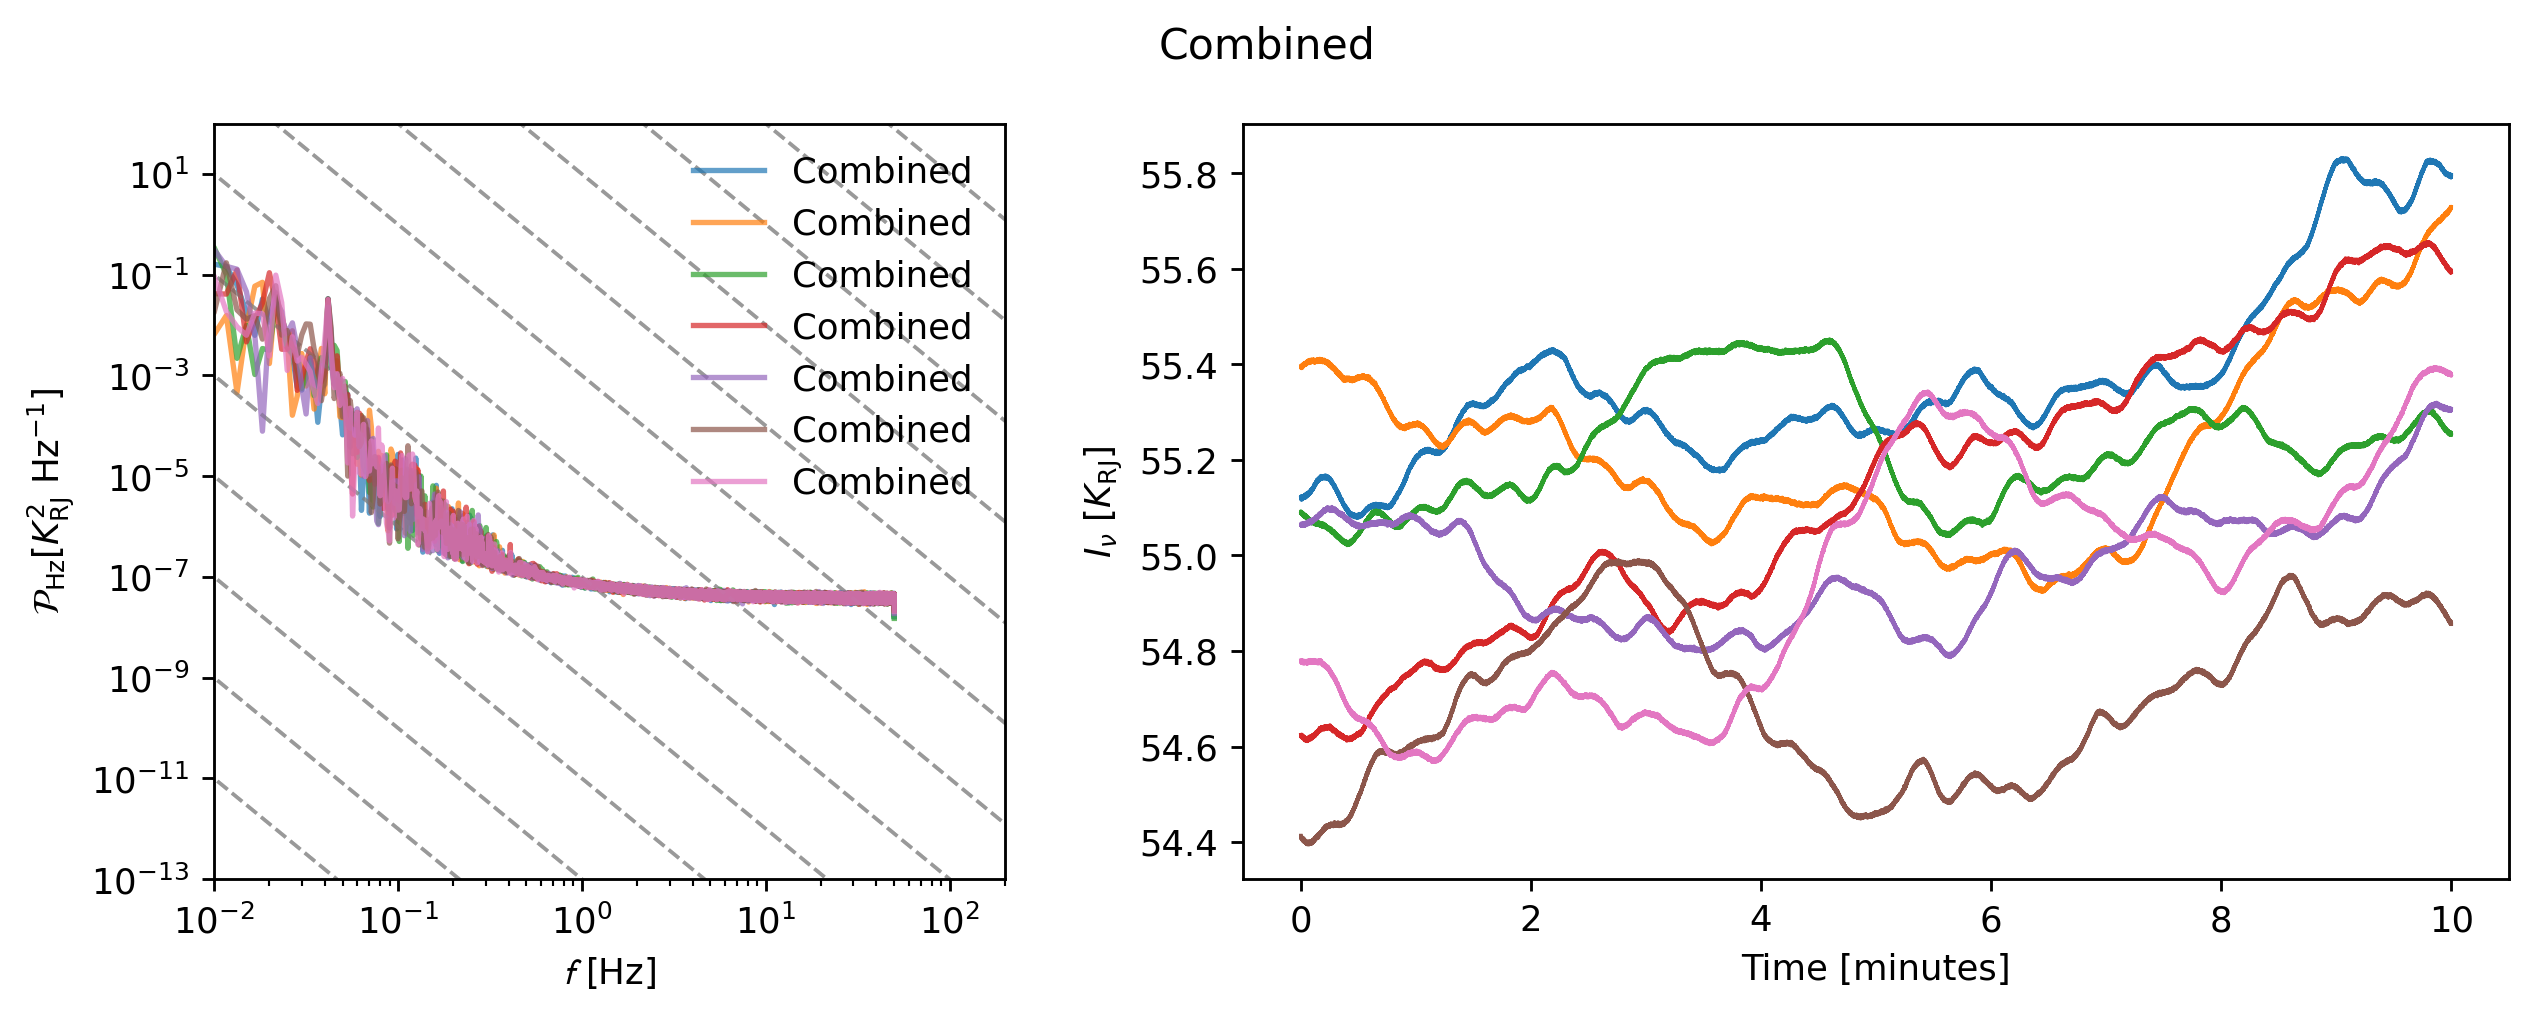

In [13]:
def plotcomponents(todarr: list) -> None:
    '''plot different realisations of the simulation for all individual components.'''
    for component in ['atmosphere', 'map', 'noise']:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=256, tight_layout=True, gridspec_kw={'width_ratios': [1, 1.6]})
        fig.suptitle(component)

        for tod in todarr:
            dt = (tod.time[1] - tod.time[0]).compute()
            data = (tod.data*tod.cal.reshape(-1,1)).compute()

            for i in range(-20,20,2): axes[0].plot(np.logspace(-7, 3,100), np.logspace(-7, 3,100) ** (-3)/1e11/(10**i), c = 'gray', alpha = 0.2, ls = '--', lw = 1)

            f_, ps_ = sp.signal.periodogram((tod.components[component] * tod.cal.reshape(-1,1)).compute(), fs=1/dt, window="tukey")
            axes[0].plot(f_[1:], ps_.mean(axis=0)[1:], alpha = .4, lw = 1, ls = '-', label = component)

            axes[0].set_xlabel(r"$\mathcal{f}$ [Hz]"),
            axes[0].set_ylabel(r"$\mathcal{P}_{\rm Hz}[K_{\rm RJ}^2~{\rm Hz}^{-1}]$")
            axes[0].loglog()
            axes[0].legend(loc = 1, frameon=False)
            axes[0].axis(xmin=1e-2, xmax = 2e2, ymin = 1e-13, ymax = 1e2)

            axes[1].set_xlabel('Time [minutes]'), axes[1].set_ylabel("\n"+r'$I_\nu$ [$K_{\rm RJ}$]')
            # axes[1].plot((tod.time - tod.time[0])/60, data[0], label = 'Real', alpha = 1., c = 'C0', lw = 1, ls = '-')
            axes[1].plot((tod.time - tod.time[0])/60, (tod.components[component]* tod.cal.reshape(-1,1))[0], label = 'Real', alpha = 1., lw = 1, ls = '-')

        plt.show()
        
    # Also plot Combined:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=256, tight_layout=True, gridspec_kw={'width_ratios': [1, 1.6]})
    fig.suptitle('Combined')

    for tod in todarr:
        dt = (tod.time[1] - tod.time[0]).compute()
        data = (tod.data*tod.cal.reshape(-1,1)).compute()

        for i in range(-20,20,2): axes[0].plot(np.logspace(-7, 3,100), np.logspace(-7, 3,100) ** (-3)/1e11/(10**i), c = 'gray', alpha = 0.2, ls = '--', lw = 1)

        f, ps = sp.signal.periodogram(data, fs=1/dt, window="tukey")
        axes[0].plot(f[1:], ps.mean(axis=0)[1:], label="Combined", alpha = 0.7, lw = 1.5, ls = '-')

        axes[0].set_xlabel(r"$\mathcal{f}$ [Hz]"),
        axes[0].set_ylabel(r"$\mathcal{P}_{\rm Hz}[K_{\rm RJ}^2~{\rm Hz}^{-1}]$")
        axes[0].loglog()
        axes[0].legend(loc = 1, frameon=False)
        axes[0].axis(xmin=1e-2, xmax = 2e2, ymin = 1e-13, ymax = 1e2)

        axes[1].set_xlabel('Time [minutes]'), axes[1].set_ylabel("\n"+r'$I_\nu$ [$K_{\rm RJ}$]')
        # axes[1].plot((tod.time - tod.time[0])/60, data[0], label = 'Real', alpha = 1., c = 'C0', lw = 1, ls = '-')
        axes[1].plot((tod.time - tod.time[0])/60, data[0], label = 'Real', alpha = 1., lw = 1, ls = '-')

    plt.show()
    
        
plotcomponents(todarr)

diff: [ 5.71276574e-04 -6.05899397e-04  1.47579782e-03 ...  6.53505778e-04
  8.65570567e-05  2.30674556e-03]
data: [55.12115234 55.11998382 55.1220785  ... 55.79539286 55.79483024
 55.79705476]
atmos: [12.146227 12.146229 12.146232 ... 12.294783 12.294784 12.294785]
diff: [ 0.00088288 -0.00225914 -0.0026097  ... -0.00310307 -0.00057128
  0.00014715]
data: [55.39585847 55.39274242 55.39241783 ... 55.72651941 55.72909881
 55.72986052]
atmos: [12.206692 12.206697 12.206703 ... 12.280434 12.280444 12.280454]
diff: [ 0.00083528  0.00160996  0.00174412 ... -0.00302084 -0.00050636
 -0.00241494]
data: [55.09207783 55.09281356 55.09290445 ... 55.25165009 55.25414293
 55.25220838]
atmos: [12.139762 12.139753 12.139744 ... 12.175775 12.17577  12.175764]
diff: [ 0.00036787 -0.00172681 -0.0004977  ...  0.00067515 -0.00123344
 -0.00206871]
data: [54.62466539 54.62253176 54.62372625 ... 55.59592213 55.59398758
 55.593122  ]
atmos: [12.036867 12.036859 12.036851 ... 12.250823 12.250817 12.250811]
diff

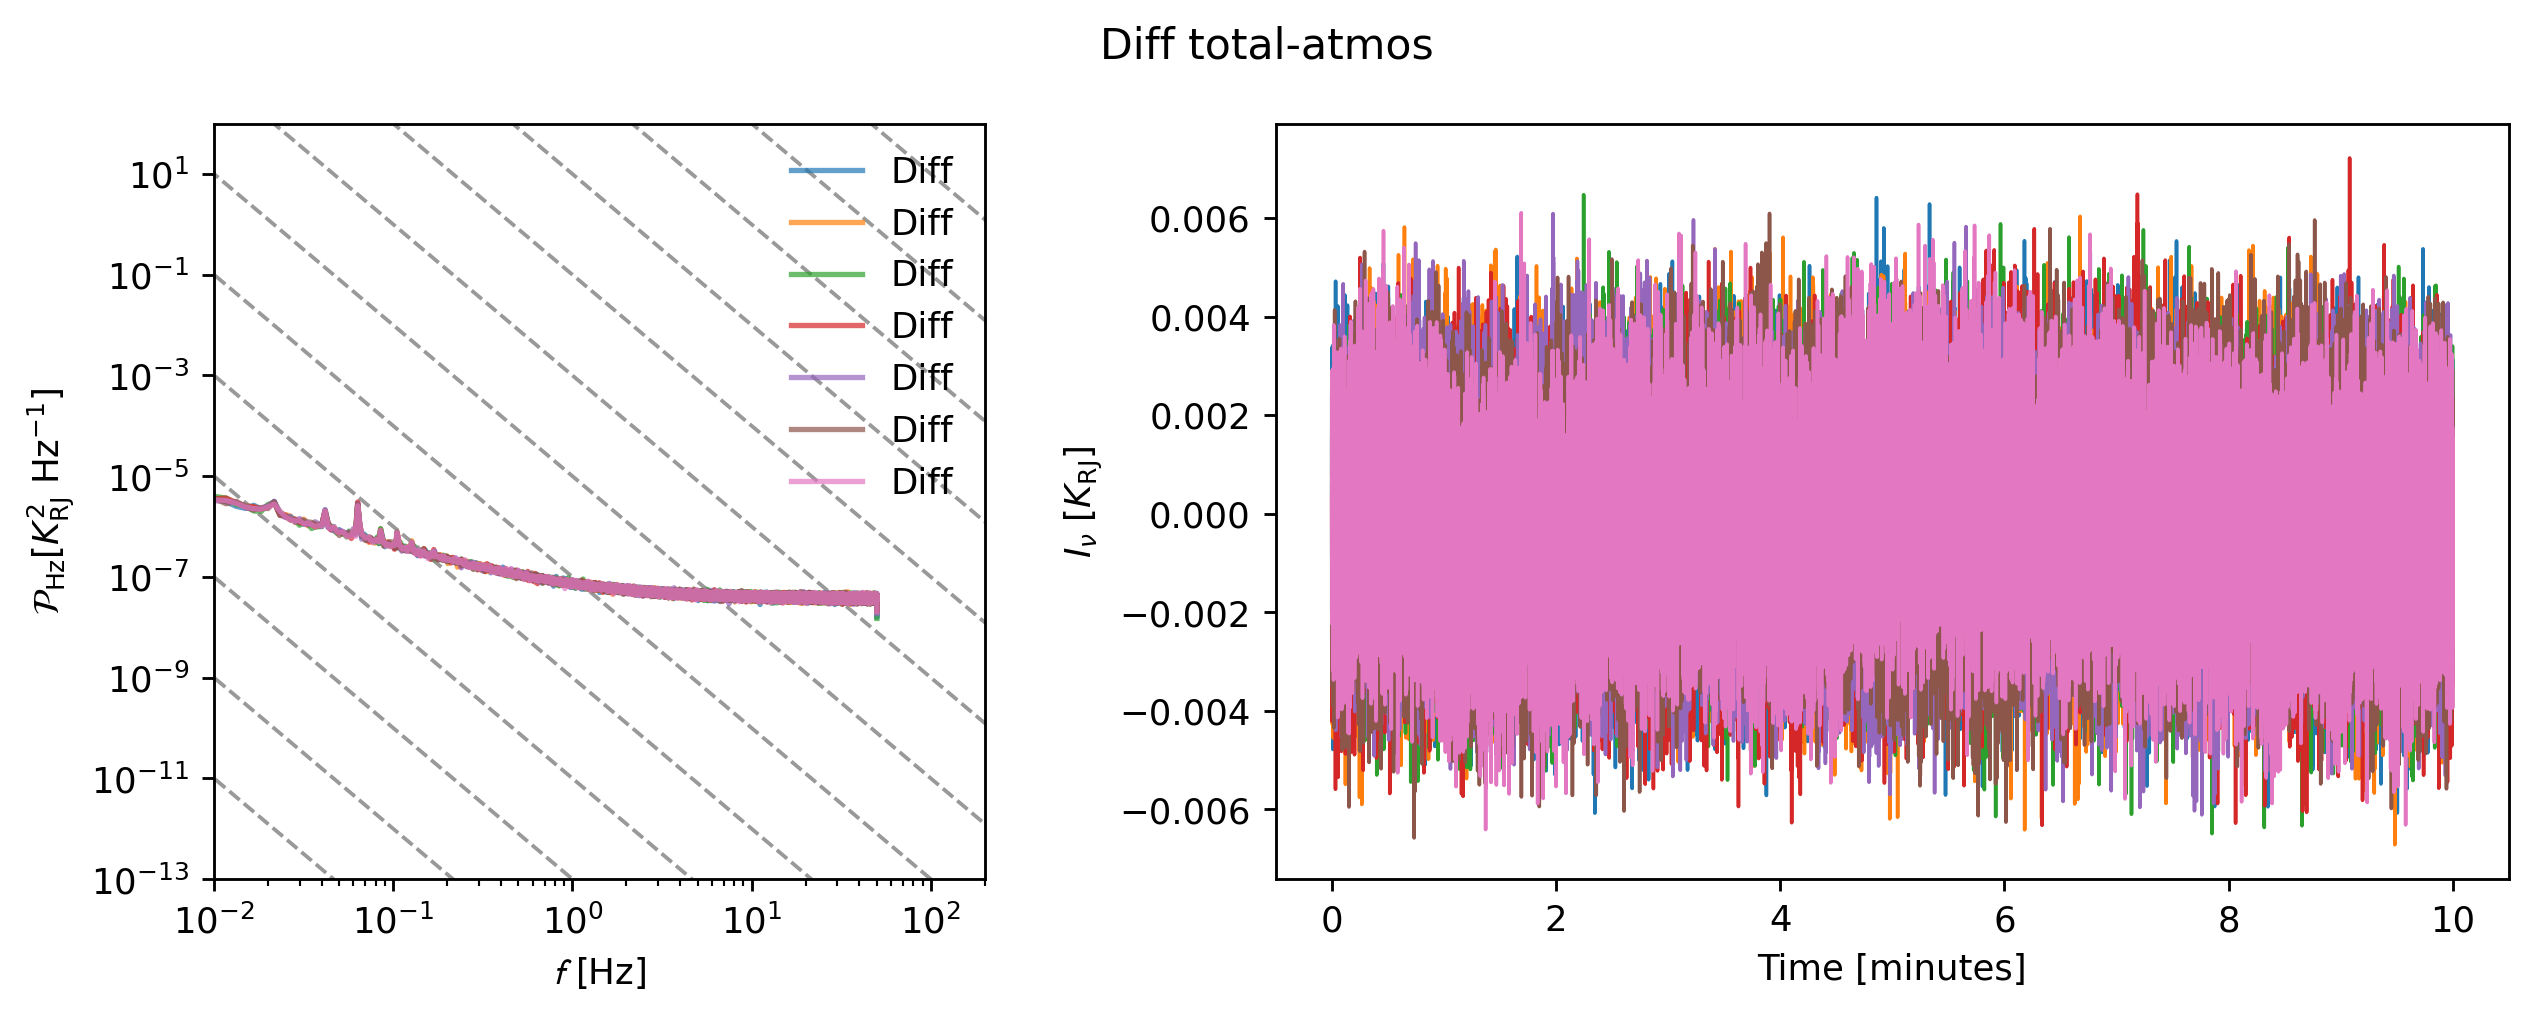

In [11]:
# Plot diff between atmospere and total:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=256, tight_layout=True, gridspec_kw={'width_ratios': [1, 1.6]})
fig.suptitle('Diff total-atmos')

for tod in todarr:
    dt = (tod.time[1] - tod.time[0]).compute()
    data = (tod.data*tod.cal.reshape(-1,1)).compute()
    diff = data - tod.components['atmosphere'] * tod.cal.reshape(-1,1)
    
    print("diff:", diff.compute()[0])
    print("data:", data[0])
    print("atmos:", tod.components['atmosphere'].compute()[0])

    for i in range(-20,20,2): axes[0].plot(np.logspace(-7, 3,100), np.logspace(-7, 3,100) ** (-3)/1e11/(10**i), c = 'gray', alpha = 0.2, ls = '--', lw = 1)

    f, ps = sp.signal.periodogram(diff, fs=1/dt, window="tukey")
    axes[0].plot(f[1:], ps.mean(axis=0)[1:], label="Diff", alpha = 0.7, lw = 1.5, ls = '-')

    axes[0].set_xlabel(r"$\mathcal{f}$ [Hz]"),
    axes[0].set_ylabel(r"$\mathcal{P}_{\rm Hz}[K_{\rm RJ}^2~{\rm Hz}^{-1}]$")
    axes[0].loglog()
    axes[0].legend(loc = 1, frameon=False)
    axes[0].axis(xmin=1e-2, xmax = 2e2, ymin = 1e-13, ymax = 1e2)

    axes[1].set_xlabel('Time [minutes]'), axes[1].set_ylabel("\n"+r'$I_\nu$ [$K_{\rm RJ}$]')
    # axes[1].plot((tod.time - tod.time[0])/60, data[0], label = 'Real', alpha = 1., c = 'C0', lw = 1, ls = '-')
    axes[1].plot((tod.time - tod.time[0])/60, diff[0], label = 'Real', alpha = 1., lw = 1, ls = '-')

plt.show()

## Try something: Fit atmospheric noise & try to remove:

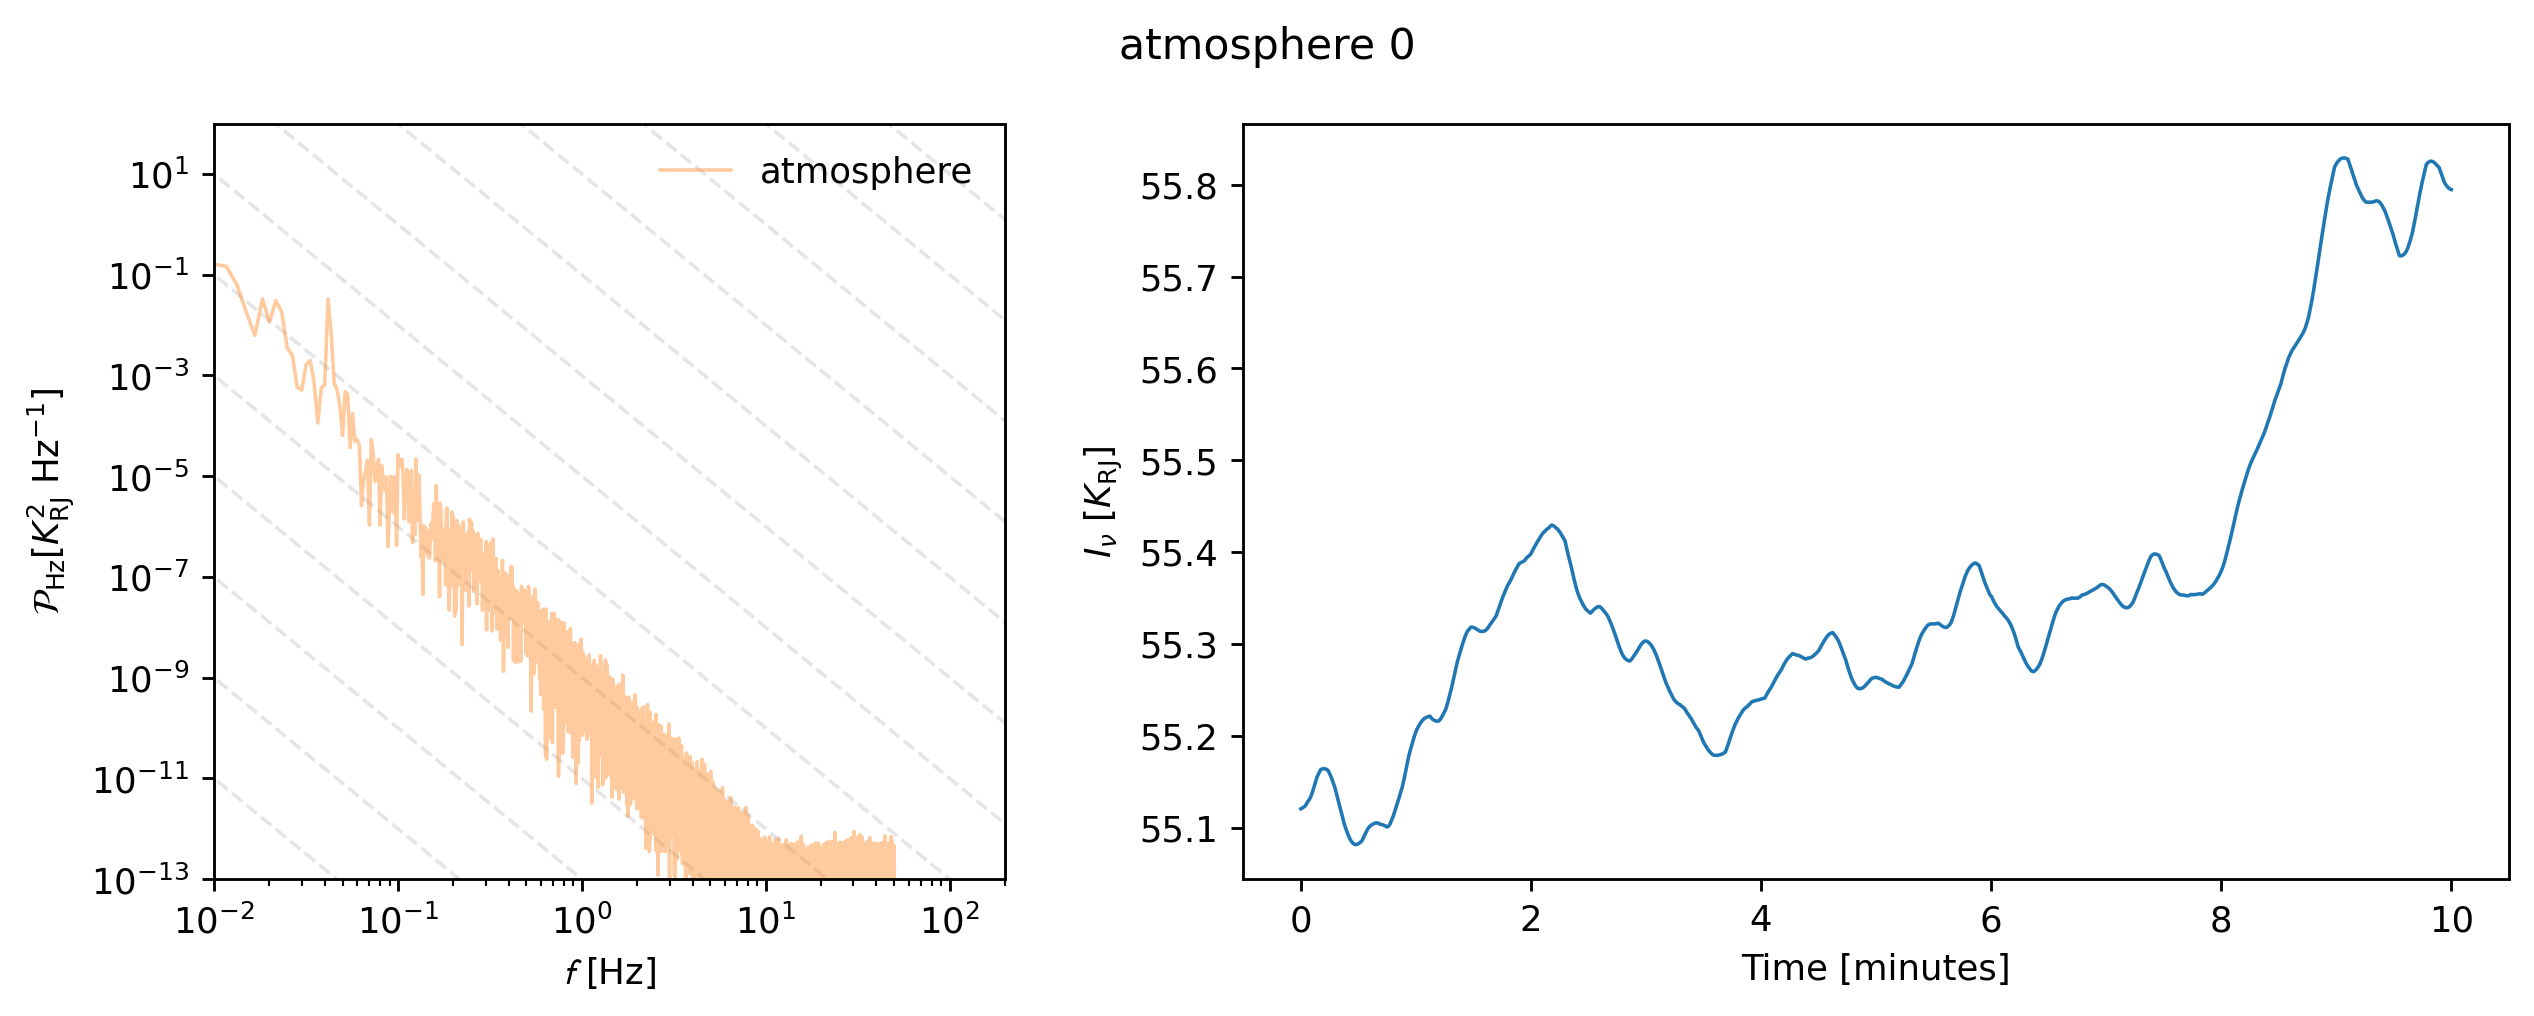

In [15]:
# Start by plotting atmospheric noise:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=256, tight_layout=True, gridspec_kw={'width_ratios': [1, 1.6]})
fig.suptitle('atmosphere 0')

for tod in todarr:
    dt = (tod.time[1] - tod.time[0]).compute()
    
    for i in range(-20,20,2): axes[0].plot(np.logspace(-7, 3,100), np.logspace(-7, 3,100) ** (-3)/1e11/(10**i), c = 'gray', alpha = 0.2, ls = '--', lw = 1)

    f_, ps_ = sp.signal.periodogram((tod.components['atmosphere'] * tod.cal.reshape(-1,1)).compute(), fs=1/dt, window="tukey")
    axes[0].plot(f_[1:], ps_.mean(axis=0)[1:], alpha = .4, c = f"C1", lw = 1, ls = '-', label = 'atmosphere')

    axes[0].set_xlabel(r"$\mathcal{f}$ [Hz]"),
    axes[0].set_ylabel(r"$\mathcal{P}_{\rm Hz}[K_{\rm RJ}^2~{\rm Hz}^{-1}]$")
    axes[0].loglog()
    axes[0].legend(loc = 1, frameon=False)
    axes[0].axis(xmin=1e-2, xmax = 2e2, ymin = 1e-13, ymax = 1e2)

    axes[1].set_xlabel('Time [minutes]'), axes[1].set_ylabel("\n"+r'$I_\nu$ [$K_{\rm RJ}$]')
    axes[1].plot((tod.time - tod.time[0])/60, (tod.components['atmosphere'] * tod.cal.reshape(-1,1))[0], label = 'Real', alpha = 1., lw = 1, ls = '-')
    
    break

plt.show()

In [77]:
# recover x,y values:
frequencies = f_[1:]
meanps = ps_.mean(axis=0)[1:]

# plt.loglog(frequencies, meanps)
# # arbitrary: cut off knee:
# frequencies = frequencies[:-int(len(frequencies)*0.8)]
# meanps = meanps[:-int(len(meanps)*0.8)]
# plt.loglog(frequencies, meanps)

optimal params: [-4.e+00  1.e-09  1.e-14]
pcov: [[ 1.52752185e-02  9.76703909e-11 -4.33864582e-06]
 [ 9.76703909e-11  6.24540409e-19 -2.78908958e-14]
 [-4.33864582e-06 -2.78908958e-14  1.78861449e-05]]


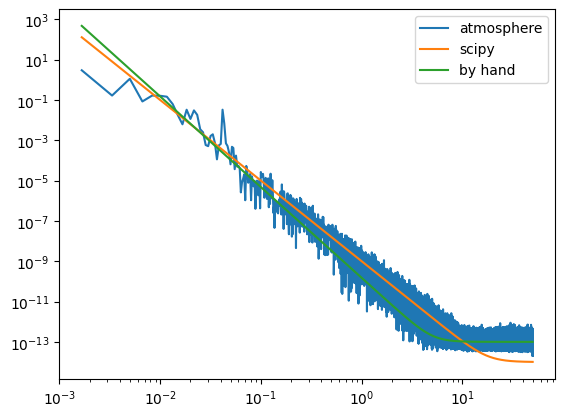

In [120]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    # simple line in log-log space
    # return np.exp(a*np.log(x)+b)
    return x**a * b + c

popt, pcov = curve_fit(func, frequencies, meanps)
popt, pcov = curve_fit(func, frequencies, meanps, bounds = ([-5., 1e-9, 1e-14], [-4., 1e-8, 1e-12]))

print("optimal params:", popt)
print("pcov:", pcov)

plt.loglog(frequencies, meanps, label='atmosphere')
plt.loglog(frequencies, func(frequencies, *popt), label='scipy')
plt.loglog(frequencies, func(frequencies, -4.5, 1.5e-10, 1e-13), label='by hand')
plt.legend()